In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
transactions    = pd.read_csv('data/sales_train.csv.gz')
items           = pd.read_csv('data/items.csv')
item_categories = pd.read_csv('data/item_categories.csv')
shops           = pd.read_csv('data/shops.csv')

In [6]:
print(transactions.shape, items.shape, item_categories.shape, shops.shape)
transactions.head()

(2935849, 6) (22170, 3) (84, 2) (60, 2)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


We have around 3 million rows of sales data for over 20000 items and 60 shops! Let's do some useful transformations on this

#### Task 1: What was the maximum total revenue among all the shops in September, 2014?

In [13]:
transactions['date'] =  pd.to_datetime(transactions['date'], format='%d.%m.%Y')

# Extract the transactions for September 2014
filter_df = transactions[(transactions['date'].dt.year==2014) & 
                         (transactions['date'].dt.month==9)]

# Add a column revenue which is the item price multiplied by the daily item count
filter_df['revenue'] = filter_df['item_price']*filter_df['item_cnt_day']

# Using pandas groupy to get the revenue for each shop.
# Taking the sum and getting the maxiumum value for our answer
answer = filter_df.groupby('shop_id')['revenue'].sum().max()

print('Max Revenue among all shops in Sep. 2014 was:', round(answer))

Max Revenue among all shops in Sep. 2014 was: 7982852.0


#### Task 2: What item category generated the highest revenue in summer 2014? (June, July, August)

In [12]:
transactions['date'] =  pd.to_datetime(transactions['date'], format='%d.%m.%Y')

# Extract the transactions for Summer 2014
filter_df = transactions[(transactions['date'].dt.year==2014) & 
                         ((transactions['date'].dt.month==6) | 
                          (transactions['date'].dt.month==7) | 
                          (transactions['date'].dt.month==8))]

# Since item categories are present in a different table, use pandas merge
filter_df = pd.merge(filter_df, items, on='item_id', how='left')
# Add a revenue column like in task 1
filter_df['revenue'] = filter_df['item_price']*filter_df['item_cnt_day']

# We don't need the maximum value but the item that holds it, we use idxmax
answer = filter_df.groupby('item_category_id')['revenue'].sum().idxmax()

print('Item category with the highest revenue in Summer 2014 was: Category', round(answer))

Item category with the highest revenue in Summer 2014 was: Category 20


#### Task 3: How many items are there, such that their price stays constant (to the best of our knowledge) during the whole period of time?

Let's assume, that the items are returned for the same price as they had been sold.

In [14]:
# Our question involves items and their price, so let's extract these columns
filter_df = transactions.loc[:,['item_id', 'item_price']]
filter_df = filter_df.groupby('item_id')

# Get the number of unique item prices for each item
num_prices = filter_df['item_price'].nunique()

# Iterate over num_prices and store required indices in list x
x = []
for index in num_prices.index:
    # If only one value for item_price, add it to our list
    if num_prices.loc[index] == 1:
        x.append(index)

# Length of this data structure is the answer we need
answer = len(x)

print('Number of items that have a constant price for the duration of the dataset are:', answer)

Number of items that have a constant price for the duration of the dataset are: 5926


#### Task 4: What was the variance of the number of sold items per day sequence for the shop with shop_id = 25 in December, 2014? Do not count the items, that were sold but returned back later.

In [15]:
shop_id = 25

transactions['date'] =  pd.to_datetime(transactions['date'], format='%d.%m.%Y')
# Filter the transactions for December 2014 for Shop 25
filter_df = transactions[((transactions['date'].dt.year == 2014) 
                          & (transactions['date'].dt.month == 12)) 
                         & (transactions['shop_id']==shop_id)]

# Select the columns useful for the question.
filter_df = filter_df.loc[:, ['date','item_id','item_cnt_day']]

In [16]:
# Use groupby to get a count for the number of items sold every day
group = filter_df.groupby('date')['item_cnt_day'].sum().rename('items').reset_index()

# Store the days present and items sold in separate variables
total_num_items_sold = group['items']
days = group['date']

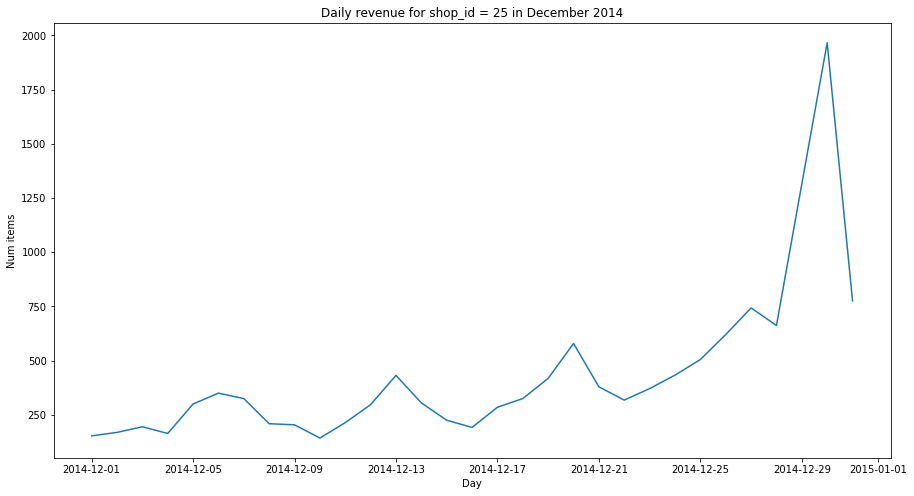

Variance of number of sold items for Shop 25 in December 2014 is: 117167.70229885059


In [23]:
plt.figure(figsize=(15, 8))

# Plotting the sale chart for December 2014 for Shop 25
plt.plot(days, total_num_items_sold)
plt.ylabel('Num items')
plt.xlabel('Day')
plt.title("Daily revenue for shop_id = 25 in December 2014")
plt.savefig('plots/daily_revenue.png', dpi=300, transparent=False)
plt.show()

total_num_items_sold_var = group['items'].var(ddof=1)
print('Variance of number of sold items for Shop 25 in December 2014 is:', total_num_items_sold_var)